In [537]:
import math
import time
from copy import deepcopy
import dill as pickle
import IPython.display as IPd
import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import torch
from matplotlib import ticker
from pyloric import create_prior, simulate, summary_stats
from pyloric.utils import energy_of_membrane, energy_of_synapse
from sbi.analysis import ActiveSubspace

import stg_energy.fig3_active_subspaces.viz as viz
from stg_energy.fig3_active_subspaces.helper_functions import nth_argmax, nth_argmin
from sklearn.linear_model import LinearRegression
from sbi.analysis import pairplot
from stg_energy.common import get_labels_8pt, generate_labels_for_pairplot
import matplotlib.patheffects as pe

# Figure 3

In [538]:
pd.options.display.max_columns = 999

In [539]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [540]:
PANEL_A = "../svg/panel_a.svg"
PANEL_B = "../svg/panel_b.svg"
PANEL_B_lin = "../svg/panel_b_lin.svg"
PANEL_B_raw = "../svg/panel_b_raw.svg"
PANEL_C = "../svg/panel_c.svg"
PANEL_D = "../svg/panel_d.svg"
PANEL_E1 = "../svg/panel_e1.svg"
PANEL_E2 = "../svg/panel_e2.svg"
PANEL_F1 = "../svg/panel_f1.svg"
PANEL_F1_raw = "../svg/panel_f1_raw.svg"
PANEL_F2 = "../svg/panel_f2.svg"
PANEL_G1 = "../svg/panel_g1.svg"
PANEL_G2 = "../svg/panel_g2.svg"
PANEL_H1 = "../svg/panel_h1.svg"
PANEL_H2 = "../svg/panel_h2.svg"
PANEL_I1 = "../svg/panel_i1.svg"
PANEL_I2 = "../svg/panel_i2.svg"
PANEL_Synapses_reduction = "../svg/panel_synapses_reduction.svg"

PANEL_supp_EV1 = "../svg/panel_supp_ev1.svg"
PANEL_supp_EV2 = "../svg/panel_supp_ev2.svg"
PANEL_supp_EV3 = "../svg/panel_supp_ev3.svg"

PANEL_supp_shift1 = "../svg/panel_supp_shift1.svg"
PANEL_supp_shift2 = "../svg/panel_supp_shift2.svg"
PANEL_supp_shift3 = "../svg/panel_supp_shift3.svg"
PANEL_supp_shift4 = "../svg/panel_supp_shift4.svg"
PANEL_supp_shift5 = "../svg/panel_supp_shift5.svg"
PANEL_supp_shift6 = "../svg/panel_supp_shift6.svg"
PANEL_supp_shift7 = "../svg/panel_supp_shift7.svg"

PANEL_supp_performance1 = "../svg/panel_supp_performance1.svg"
PANEL_supp_performance2 = "../svg/panel_supp_performance2.svg"
PANEL_supp_performance3 = "../svg/panel_supp_performance3.svg"

PANEL_supp_synapses1 = "../svg/panel_supp_synapses1.svg"
PANEL_supp_synapses2 = "../svg/panel_supp_synapses2.svg"
PANEL_supp_synapses3 = "../svg/panel_supp_synapses3.svg"

PANEL_NEW_A = "../svg/panel_new_a_inkscape.svg"

PANEL_NEW_F1 = "../svg/panel_new_f1.svg"
PANEL_NEW_F2 = "../svg/panel_new_f2.svg"

PANEL_NEW_G1 = "../svg/panel_new_g1.svg"
PANEL_NEW_G2 = "../svg/panel_new_g2.svg"
PANEL_NEW_supp_params_11 = "../svg/PANEL_NEW_supp_params_11.svg"
PANEL_NEW_supp_params_12 = "../svg/PANEL_NEW_supp_params_12.svg"
PANEL_NEW_supp_params_21 = "../svg/PANEL_NEW_supp_params_21.svg"
PANEL_NEW_supp_params_22 = "../svg/PANEL_NEW_supp_params_22.svg"

PANEL_MECH_KD_A = "../svg/panel_mech_kd_a_new.svg"
PANEL_MECH_KD_B = "../svg/panel_mech_kd_b_new.svg"
PANEL_MECH_KD_C = "../svg/panel_mech_kd_c_new.svg"
PANEL_MECH_KD_D = "../svg/panel_mech_kd_d_new.svg"
PANEL_MECH_KD_E = "../svg/panel_mech_kd_e_new.svg"
PANEL_MECH_KD_F = "../svg/panel_mech_kd_f_new.svg"
PANEL_MECH_KD_voltage = "../svg/panel_mech_kd_voltage_new.svg"
PANEL_lin_reg = "../svg/panel_lin_reg.svg"
PANEL_degeneracy_plot = "../svg/panel_degeneracy_plot.svg"

### Load experimental data

In [541]:
prior_11 = create_prior()

In [430]:
theta = pd.read_pickle(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_circuit_parameters.pkl"
)
x = pd.read_pickle(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_simulation_outputs.pkl"
)
seeds = np.load(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_seeds.npy"
)

theta_np = theta.to_numpy()
x_np = x.to_numpy()

### Simulate 10 samples and keep track of the energy consumption of each trace

In [431]:
def simulator(p_with_s):
    circuit_params = np.asarray([p_with_s[:-1]])
    theta_pd = pd.DataFrame(circuit_params, columns=theta.columns)
    out_target = simulate(
        theta_pd.loc[0], seed=int(p_with_s[-1]), track_energy=True, track_currents=True
    )
    all_energies = energy_of_membrane(out_target)
    synaptic_energies = energy_of_synapse(out_target)

    summed_energy_each_current = np.sum(all_energies, axis=2)
    summed_energy_synapses = np.sum(synaptic_energies, axis=1)
    summed_energy_total = np.sum(all_energies) + np.sum(synaptic_energies)
    fraction_of_each_current = summed_energy_each_current / summed_energy_total
    fraction_of_synapse = summed_energy_synapses / summed_energy_total
    return (fraction_of_each_current, fraction_of_synapse)

In [432]:
# torch.manual_seed(0)
# params_with_seeds = np.concatenate(
#     (
#         theta_np[:200],
#         seeds[:200][
#             None,
#         ].T,
#     ),
#     axis=1,
# )
# simulation_outputs = list(map(simulator, params_with_seeds))
simulation_outputs = np.load("../../../results/simulation_data_Tube_MLslurm_cluster/twohundred_predictives_individual_currents.npy", allow_pickle=True)

In [433]:
# np.save("../../../results/simulation_data_Tube_MLslurm_cluster/twohundred_predictives_individual_currents.npy", simulation_outputs)

In [434]:
all_e_cur = []
all_e_syn = []
for so in simulation_outputs:
    e_cur, e_syn = so
    all_e_cur.append(e_cur)
    all_e_syn.append(e_syn)

all_e_cur = np.asarray(all_e_cur)
all_e_syn = np.asarray(all_e_syn)
fractions = np.mean(all_e_cur, axis=0)
synapse_fractions = np.mean(all_e_syn, axis=0)

In [435]:
summed_energy_synapses = np.sum(all_e_syn, axis=1)

In [436]:
summed_energy_membrane = np.sum(np.sum(all_e_cur, axis=1), axis=1)

In [437]:
fraction_between_them = summed_energy_synapses / (summed_energy_membrane + summed_energy_synapses)

In [438]:
print("Fraction of energy consumed by synapses:   ", np.mean(fraction_between_them)*100, "%")

Fraction of energy consumed by synapses:    0.07815773482273314 %


In [439]:
current_fractions = fractions.T.flatten()
all_fractions = np.concatenate((current_fractions, synapse_fractions))
all_fractions /= np.linalg.norm(all_fractions)

###  Fit regression net for total energy

In [440]:
import sys
sys.path.append("home/michael/Documents/sbi/sbi/utils/user_input_checks_utils")

In [441]:
import sys
from sbi.utils import user_input_checks_utils

sys.modules["sbi.user_input.user_input_checks_utils"] = user_input_checks_utils

In [442]:
with open(
    "../../../results/trained_neural_nets/inference/posterior_11deg.pickle", "rb"
) as handle:
    posterior = pickle.load(handle)
    posterior._device = 'cpu'

/home/michael/Documents/sbi/sbi/inference/posteriors/base_posterior.py:1089: UserWarning: You had saved the posterior under an older version of `sbi`. To make the loaded version comply with the version you are using right now, we had to set the following attributes: `self._device = cpu` `self._num_iid_trials = None` `self._iid_methods = ['snle', 'snre_a', 'snre_b']` `self._allow_iid_x = False` `self._sample_with = rejection`
  warn(warning_description + warning_msg)


In [443]:
xo = np.load("../../../results/experimental_data/xo_11deg.npy")

In [444]:
energies = x["energies"]

In [445]:
energies_tt = torch.as_tensor(energies.to_numpy())
x_tt = torch.as_tensor(x_np, dtype=torch.float32)

In [446]:
num_test = 1000

theta_test = torch.as_tensor(theta_np[:num_test], dtype=torch.float32)
theta_train = torch.as_tensor(theta_np[num_test:], dtype=torch.float32)

In [447]:
train_energy = torch.as_tensor(
    torch.sum(energies_tt[num_test:], dim=1).unsqueeze(1), dtype=torch.float32
)
test_energy = torch.as_tensor(
    torch.sum(energies_tt[:num_test], dim=1).unsqueeze(1), dtype=torch.float32
)

In [448]:
posterior._sample_with = "rejection"

### Compute the same thing for several quantiles and plot it

In [263]:
base = 4.0
mylist =[0.001]
while mylist[-1] < (1/base):
    mylist.append(deepcopy(mylist[-1]) * base)

In [264]:
mylist

[0.001, 0.004, 0.016, 0.064, 0.256]

In [265]:
mylist.append(1.0)
mylist = np.asarray(mylist)

In [266]:
sorted_energies = summed_energies[inds]
num_vals = sorted_energies.shape[0]
fracs = []
eval_quantiles = np.flip(1 - mylist)

In [267]:
eval_quantiles

array([0.   , 0.744, 0.936, 0.984, 0.996, 0.999])

In [268]:
sorted_energies = summed_energies[inds]
num_vals = sorted_energies.shape[0]
fracs = []
eval_quantiles = np.flip(mylist)
for quantile in eval_quantiles:
    if quantile == 1.0:
        fracs.append([1.0]*31)
    else:
        one_percent_quantile = int(num_vals * quantile)
        one_percent_energy = sorted_energies[one_percent_quantile]

        min_energy_condition = summed_energies < one_percent_energy
        min_energy_theta = theta_np[min_energy_condition]
        print("np.", np.shape(min_energy_theta))

        std_of_min_energy = np.std(min_energy_theta, axis=0)
        std_of_all_samples = np.std(theta_np, axis=0)

        fracs.append(std_of_min_energy / std_of_all_samples)

fracs = np.asarray(fracs)
fracs[fracs > 1.0] = 1.0

np. (9200, 31)
np. (2300, 31)
np. (575, 31)
np. (143, 31)
np. (35, 31)


In [313]:
cols_hex = [
    "#1b9e77",
    "#d95f02",
    "#7570b3",
    "#e7298a",
    "#66a61e",
    "#e6ab02",
    "#a6761d",
    "#666666",
    "#1b9e77",
    "#d95f02",
    "#7570b3",
    "#e7298a",
    "#66a61e",
    "#e6ab02",
    "#a6761d",
    "#666666",
    "#1b9e77",
    "#d95f02",
    "#7570b3",
    "#e7298a",
    "#66a61e",
    "#e6ab02",
    "#a6761d",
    "#666666",
    "k",
    "k",
    "k",
    "k",
    "k",
    "k",
    "k",
]
cols = np.asarray(cols_hex)

In [314]:
cols

array(['#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#66a61e', '#e6ab02',
       '#a6761d', '#666666', '#1b9e77', '#d95f02', '#7570b3', '#e7298a',
       '#66a61e', '#e6ab02', '#a6761d', '#666666', '#1b9e77', '#d95f02',
       '#7570b3', '#e7298a', '#66a61e', '#e6ab02', '#a6761d', '#666666',
       'k', 'k', 'k', 'k', 'k', 'k', 'k'], dtype='<U7')

In [333]:
styles = ["solid", "dotted", "dashed"]*8
styles += ["dotted"]*7

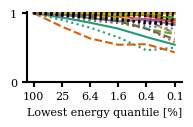

In [553]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2.0, 0.9))

    for f, c, s in zip(fracs.T, cols, styles):
        _ = ax.plot(f, c=c, linestyle=s)

    _ = ax.set_xticks(range(len(eval_quantiles)))
    vals = 1-np.asarray(eval_quantiles)
    l = [str(round(100-float(100*label), 6)) for label in vals]
    l[0] = "100"
    l[1] = "25"
    _ = ax.set_xticklabels(l)
    ax.set_xlabel("Lowest energy quantile [%]")
    ax.set_yticks([0., 1.])
#     ax.set_ylabel("Degeneracy")
    ax.set_ylim([0, 1.01])    
    plt.savefig(PANEL_degeneracy_plot, facecolor="None", transparent=False)

### Variance reduction plot

In [449]:
summed_energies = np.sum(x['energies'].to_numpy(), axis=1) / 10 / 1000

In [450]:
inds = np.argsort(summed_energies)

In [451]:
sorted_energies = summed_energies[inds]
num_vals = sorted_energies.shape[0]
quantile = 0.02
one_percent_quantile = int(num_vals * quantile)
ninenine_percent_quantile = int(num_vals * (1-quantile))
one_percent_energy = sorted_energies[one_percent_quantile]
ninenine_percent_energy = sorted_energies[ninenine_percent_quantile]

In [452]:
min_energy_condition = summed_energies < one_percent_energy
max_energy_condition = summed_energies > ninenine_percent_energy

In [453]:
min_energy_theta = theta_np[min_energy_condition]
max_energy_theta = theta_np[max_energy_condition]

min_energy_energies = summed_energies[min_energy_condition]
max_energy_energies = summed_energies[max_energy_condition]

In [454]:
prior = create_prior(as_torch_dist=True)
lower_b = prior.support.base_constraint.lower_bound.unsqueeze(0)
upper_b = prior.support.base_constraint.upper_bound.unsqueeze(0)
limits = torch.cat((lower_b, upper_b), dim=0).T

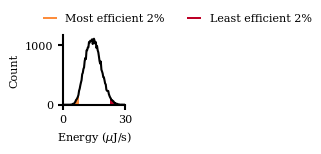

In [512]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(0.8, 0.9))
    vals, xvals = np.histogram(summed_energies, bins=100, range=[0, 30])
    val_dist = xvals[1] - xvals[0]
    ax.plot(xvals[1:] - val_dist/2, vals, c='k')
    _, _, one = ax.hist(min_energy_energies, bins=100, range=[0, 30], color='#fd8d3c')
    _, _, two = ax.hist(max_energy_energies, bins=100, range=[0, 30], color='#bd0026')
    ax.set_xlabel("Energy ($\mu$J/s)")
    ax.set_ylabel("Count")
    ax.set_xlim([0, 30])
    ax.set_xticks([0, 30])
    leg = ax.legend([one, two], ["Most efficient 2%", "Least efficient 2%"], ncol=3, loc=((-0.4, 1.1)), handletextpad=0.02)
    for line in leg.get_patches():
        line.set_height(1.6)
        line.set_width(10.0)
        line.set_y(2.3)
    plt.savefig(PANEL_supp_shift1, facecolor="None", transparent=False)

In [456]:
std_of_min_energy = np.std(min_energy_theta, axis=0)
std_of_all_samples = np.std(theta_np, axis=0)

In [457]:
stds_fraction = 1 - (std_of_min_energy / std_of_all_samples)

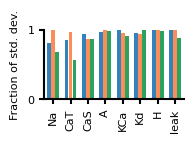

In [534]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.py_sensitivity_bars_cosyne(
        1.0 - deepcopy(torch.as_tensor(stds_fraction)),
        ylim=[0.0, 1.0],
        figsize=(1.8, 0.9),
        ylabel="Fraction of std. dev.",
        title=None,
        title_x_offset=-1.1,
        title_y_offset=0.1,
        legend_y_offset=0.3,
        legend=False,
        yticks=[0, 1],
        ylabelpad=5.5,
        rotation=90,
        spacing=0.23
    )
    plt.savefig(PANEL_supp_shift7, facecolor="None", transparent=False)
    plt.show()

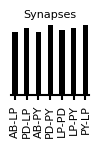

In [527]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.synapse_sensitivity_bars(
        1.0 - deepcopy(torch.as_tensor([stds_fraction[-7:]])),
        ylim=[0.0, 1.0], 
        figsize=(1.0, 0.9), 
        ylabel=None, 
        color="k", 
        title="Synapses",
        width_multiplier=0.5
    )
    plt.savefig(PANEL_Synapses_reduction, facecolor="None", transparent=False)
    plt.show()

### Concrete plots

In [461]:
labels_ = get_labels_8pt()

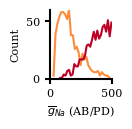

In [495]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(0.8, 0.9))
    ind=0
    vals, xvals = np.histogram(min_energy_theta[:, ind], bins=30)
    val_dist = xvals[1] - xvals[0]
    one, = ax.plot(xvals[1:] - val_dist/2, vals, color='#fd8d3c')
#     vals, xvals = np.histogram(theta_np[:, ind], bins=30)
#     val_dist = xvals[1] - xvals[0]
#     ax.plot(xvals[1:] - val_dist/2, vals/30, color='k', alpha=0.7)
    vals, xvals = np.histogram(max_energy_theta[:, ind], bins=30)
    two, = ax.plot(xvals[1:], vals, color='#bd0026')
    ax.set_xlabel(r"$\overline{g}_{Na}$ (AB/PD)")
    ax.set_ylabel("Count")
    ax.set_xlim(limits[ind])
    ax.set_xticks(limits[ind])
#     ax.legend([one, two], ["Most efficient 2%", "Least efficient 2%"], ncol=3, loc=((0.0, 1)))
    ax.set_ylim(bottom=0)
    ax.set_ylim([0, 60])
    plt.savefig(PANEL_supp_shift2, facecolor="None", transparent=False)

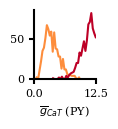

In [463]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(0.8, 0.9))
    ind = 17
    vals, xvals = np.histogram(min_energy_theta[:, ind], bins=30)
    val_dist = xvals[1] - xvals[0]
    one, = ax.plot(xvals[1:] - val_dist/2, vals, color='#fd8d3c')
    vals, xvals = np.histogram(max_energy_theta[:, ind], bins=30)
    two, = ax.plot(xvals[1:], vals, color='#bd0026')
    ax.set_xlabel(r"$\overline{g}_{CaT}$ (PY)")
    ax.set_xlim(limits[ind])
    ax.set_xticks(limits[ind])
    ax.set_ylim(bottom=0)
#     ax.legend([one, two], ["Most efficient 2%", "Least efficient 2%"], ncol=3, loc=((0.0, 1)))
    plt.savefig(PANEL_supp_shift3, facecolor="None", transparent=False)

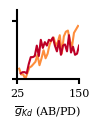

In [492]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(0.8, 0.9))
    ind = 5
    vals, xvals = np.histogram(min_energy_theta[:, ind], bins=30)
    val_dist = xvals[1] - xvals[0]
    ax.plot(xvals[1:] - val_dist/2, vals, color='#fd8d3c')
    vals, xvals = np.histogram(max_energy_theta[:, ind], bins=30)
    ax.plot(xvals[1:], vals, color='#bd0026')
    ax.set_xlabel(r"$\overline{g}_{Kd}$ (AB/PD)")
    ax.set_xlim(limits[ind])
    ax.set_xticks(limits[ind])
    ax.set_ylim(bottom=0)
    ax.set_yticklabels([])
    ax.set_yticks([0, 50])
    ax.set_ylim([0, 60])
    plt.savefig(PANEL_supp_shift4, facecolor="None", transparent=False)

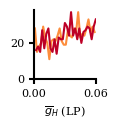

In [465]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(0.8, 0.9))
    ind = 14
    vals, xvals = np.histogram(min_energy_theta[:, ind], bins=30)
    val_dist = xvals[1] - xvals[0]
    ax.plot(xvals[1:] - val_dist/2, vals, color='#fd8d3c')
    vals, xvals = np.histogram(max_energy_theta[:, ind], bins=30)
    ax.plot(xvals[1:], vals, color='#bd0026')
    ax.set_xlabel(r"$\overline{g}_{H}$ (LP)")
    ax.set_xlim(limits[ind])
    ax.set_xticks(limits[ind])
    ax.set_ylim(bottom=0)
    plt.savefig(PANEL_supp_shift5, facecolor="None", transparent=False)

### Panel C

In [466]:
prior = create_prior(as_torch_dist=True)
lower_b = prior.support.base_constraint.lower_bound.unsqueeze(0)
upper_b = prior.support.base_constraint.upper_bound.unsqueeze(0)
limits = torch.cat((lower_b, upper_b), dim=0).T 

In [467]:
npz = np.load('../../../results/experimental_data/trace_data_845_082_0044.npz')
t = npz['t']
PD_spikes = npz['PD_spikes']
LP_spikes = npz['LP_spikes']
PY_spikes = npz['PY_spikes']
pdn = npz['pdn']
lpn = npz['lpn']
pyn = npz['pyn']
start_index = 219500 + 2100
end_index   = 246500 + 2100  # 32000
height_offset = 200
shown_t = t[end_index] - t[start_index]
time_len = shown_t / 0.025 * 1000
dt = t[1] - t[0]
time_vec = np.arange(0, 11000, 0.025)

In [47]:
inds = np.argsort(summed_energies)
quantile = 0.00015
sorted_energies = summed_energies[inds]
num_vals = sorted_energies.shape[0]
one_percent_quantile = int(num_vals * quantile)
one_percent_energy = sorted_energies[one_percent_quantile]

In [48]:
min_energy_condition = summed_energies < one_percent_energy
min_energy_theta = theta_np[min_energy_condition]
min_energy_energies = summed_energies[min_energy_condition]
min_energy_x = x[min_energy_condition]
min_energy_seed = seeds[min_energy_condition]

In [49]:
labels_ = get_labels_8pt()
lims=limits.numpy()
all_labels = generate_labels_for_pairplot(lims)

/home/michael/Documents/sbi/sbi/utils/plot.py:563: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if opts["labels"] == [] or opts["labels"] is None:
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif


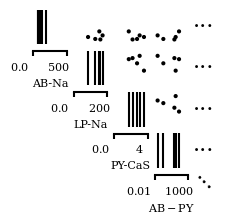

In [50]:
with mpl.rc_context(fname='../../../.matplotlibrc'):

    labels_new = get_labels_8pt()
    new_labels = []
    for l in labels_new:
        new_labels.append(l+'    '+r'$\;\;$')
    labels_new = new_labels
    labels_new[9] += ''

    fig, axes = pairplot(
        samples=min_energy_theta,
        subset=[0,8,18,26],
        labelpad=1,
        tick_labelpad=1,
        limits=limits,
        ticks=limits,
        tick_labels=all_labels,
        figsize=(2.0, 2.0),
        labels=labels_,
        scatter_offdiag={'rasterized':True, 'alpha':1.0},
        diag=['scatter'],
        upper=['scatter'],
        samples_colors="k",
        hist_offdiag={'bins':50},
        plot_offdiag={'linewidth': 1.6, 'path_effects':[pe.Stroke(linewidth=2.4, foreground='k'), pe.Normal()]}
    )
    plt.savefig(PANEL_NEW_A, facecolor='None', transparent=True)

### Panel E

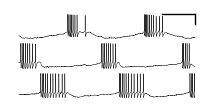

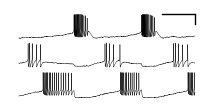

In [53]:
with mpl.rc_context(fname='../../../.matplotlibrc'):
    viz.plot_overall_efficient(
        1, min_energy_theta, min_energy_seed, time_vec, time_len, offset=90000, figsize=(2.5, 1.2)
    )
    plt.savefig(PANEL_NEW_F1, facecolor='None', transparent=True)

    viz.plot_overall_efficient(
        3, min_energy_theta, min_energy_seed, time_vec, time_len, figsize=(2.5, 1.2)
    )
    plt.savefig(PANEL_NEW_F2, facecolor='None', transparent=True)

### Panel F

3.88169053624513
4.163538616011244


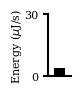

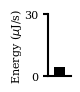

In [54]:
with mpl.rc_context(fname='../../../.matplotlibrc'):
    viz.plot_energy_of_theta(
        1, min_energy_theta, min_energy_seed, time_vec, time_len, offset=90000, figsize=(0.3, 0.8)
    )
    plt.savefig(PANEL_NEW_G1, facecolor='None', transparent=True)

    viz.plot_energy_of_theta(
        3, min_energy_theta, min_energy_seed, time_vec, time_len, figsize=(0.3, 0.8)
    )
    plt.savefig(PANEL_NEW_G2, facecolor='None', transparent=True)

### Panel G

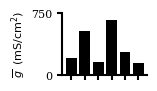

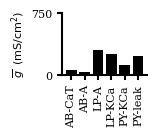

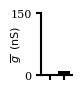

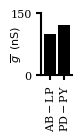

In [55]:
with mpl.rc_context(fname='../../../.matplotlibrc'):
    viz.plot_params(deepcopy(min_energy_theta[1]), [1, 3, 11, 12, 20, 23, 24, 27], labels=False, width=1.1, ylim=[0, 750], labelpad=2, height=0.8)
    plt.savefig(PANEL_NEW_supp_params_11, facecolor='None', transparent=True)
    viz.plot_params(deepcopy(min_energy_theta[3]), [1, 3, 11, 12, 20, 23, 24, 27], width=1.1, ylim=[0, 750], labelpad=2, height=0.8)
    plt.savefig(PANEL_NEW_supp_params_12, facecolor='None', transparent=True)

    viz.plot_synapses(deepcopy(min_energy_theta[1]), [1, 3, 11, 12, 20, 23, 24, 27], labels=False, width=0.4, height=0.8)
    plt.savefig(PANEL_NEW_supp_params_21, facecolor='None', transparent=True)
    viz.plot_synapses(deepcopy(min_energy_theta[3]), [1, 3, 11, 12, 20, 23, 24, 27], width=0.4, height=0.8)
    plt.savefig(PANEL_NEW_supp_params_22, facecolor='None', transparent=True)

### Assemble figure

In [344]:
def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [560]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_text_12pt = {'size': '12pt', 'font': 'Arial', 'weight': '500'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}
kwargs_text8pt_blue = {'size': '7.7pt', 'font': 'Arial', 'weight': '500', 'color': "#0570b0"}

f = Figure("20.3cm", "9.9cm",

    Panel(
          SVG(PANEL_supp_shift1).scale(svg_scale).move(0, 0*factor_svg),
        Text("a", 4.0*factor_svg, 3.5*factor_svg, **kwargs_text),
    ).move(-4*factor_svg, -1*factor_svg),
           
    Panel(
          SVG(PANEL_supp_shift3).scale(svg_scale).move(0, 0*factor_svg),
    ).move(16.7*factor_svg, 3.4*factor_svg),
    
    Panel(
          SVG(PANEL_supp_shift4).scale(svg_scale).move(0, 0*factor_svg),
    ).move(34.0*factor_svg, 3.4*factor_svg),
    
    Panel(
          SVG(PANEL_Synapses_reduction).scale(svg_scale).move(0, 0*factor_svg),
    ).move(87.0*factor_svg, 0.6*factor_svg),

    Panel(
          SVG(PANEL_supp_shift7).scale(svg_scale).move(0, 0*factor_svg),
          Text("b", -1.15*factor_svg, 2.4*factor_svg, **kwargs_text),
    ).move(55.65*factor_svg, 0.1*factor_svg),
           
    Panel(
          SVG("../svg/panel_legend_4cols.svg").scale(svg_scale).move(0, 0*factor_svg),
    ).move(65.2*factor_svg, 1.9*factor_svg),

    Panel(
          SVG(PANEL_degeneracy_plot).scale(svg_scale).move(0, 0*factor_svg),          
        Text("c", 0.15*factor_svg, 0.4*factor_svg, **kwargs_text),
    ).move(109.7*factor_svg, 2.7*factor_svg),
           
    Panel(
          SVG(PANEL_NEW_A).scale(svg_scale*1.03).move(0*factor_svg, 0*factor_svg),
          Text("d", -2*factor_svg, 1.5*factor_svg, **kwargs_text),
    ).move(2*factor_svg, 27*factor_svg),

    Panel(
        SVG(PANEL_NEW_F1).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("e", -.0*factor_svg, 2.8*factor_svg, **kwargs_text),
    ).move(44.0*factor_svg, 25.7*factor_svg),

    Panel(
        SVG(PANEL_NEW_F2).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(44.0*factor_svg, 45.5*factor_svg),

    Panel(
        SVG(PANEL_NEW_G1).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("f", -2.2*factor_svg, 1.7*factor_svg, **kwargs_text),
    ).move(86.7*factor_svg, 26.8*factor_svg),
           
    Panel(
        SVG(PANEL_NEW_G2).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(86.7*factor_svg, 46.5*factor_svg),

    Panel(
        SVG(PANEL_NEW_supp_params_11).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("g", -1.7*factor_svg, 1.7*factor_svg, **kwargs_text),
    ).move(103.7*factor_svg, 26.8*factor_svg),

    Panel(
        SVG(PANEL_NEW_supp_params_12).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(103.7*factor_svg, 46.5*factor_svg),

    Panel(
        SVG(PANEL_NEW_supp_params_21).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(127.5*factor_svg, 26.8*factor_svg),

    Panel(
        SVG(PANEL_NEW_supp_params_22).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(127.5*factor_svg, 46.5*factor_svg),
)

!mkdir -p fig
f.save("../fig/fig3_1.svg")
svg('../fig/fig3_1.svg')